# U-Net analysis

The following is a u-net analysis based off the templates for torchio found at https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=p-V_kHC5BvST

We will train a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) to perform the landmark detection of the corneas and rhabdoms

In [1]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.75
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

Install the following via terminal
```bash
sudo apt install tree
```

Install some pypi packages

In [2]:
!pip install --quiet --upgrade pip
!pip install --quiet unet==0.7.7
!pip install --quiet torchio==0.18.33

Install pytorch following recommendations at https://pytorch.org/

For me, this was running the following command:

```bash
pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
```

Import packages

In [3]:
import enum
import os
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('TorchIO version:', tio.__version__)

TorchIO version: 0.18.33


# Data
# Viewing dataset files
We will use the tree program to view our file structure

In [4]:
dataset_dir_name = 'dataset'

!tree -d {dataset_dir_name}

dataset
├── images_10 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/images_10
├── images_15 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/images_15
├── images_20 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/images_20
├── images_25 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/images_25
├── labels_10 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/labels_10
├── labels_15 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/labels_15
├── labels_20 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/labels_20
├── labels_25 -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/labels_25
└── raw_images -> //mnt/d37c99c5-3b94-47b9-9965-c66fd9a16e23/jake/mctnet_data/raw_images

9 directories


## Making the subjects dataset
This is a torchio data format that lets you easily modify the subjects with transforms (e.g. to generate new training data via data augmentation) and load it efficiently to the model with a DataLoader.

It receives as input a list of torchio.Subject instances and an optional torchio.transforms.Transform.

The inputs to the subject class are instances of torchio.Image, such as torchio.ScalarImage (for scalars) or torchio.LabelMap (for categories). The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

In [5]:
image_dir = f'{dataset_dir_name}/images_10/'
label_dir = f'{dataset_dir_name}/labels_10/'

# find all the .nii files
images = []
labels = []

for file in os.listdir(image_dir):
    if file.endswith('.nii'):
        images.append(image_dir + file)
        
for file in os.listdir(label_dir):
    if file.endswith('.nii'):
        labels.append(label_dir + file)


# find the matching pairs by their filename
images_p = []
for img in images:
    images_p.append(Path(img).stem)
    
labels_p = []
for label in labels:
    name = (Path(label).stem).replace('_corneas', '').replace('_rhabdoms', '')
    labels_p.append(name)
    
filenames = sorted(list(set(images_p) & set(labels_p)))

print(f'Found {len(filenames)} labelled images for analysis')

# now add them to a list of subjects
subjects_list = []

for filename in filenames:
    subject = tio.Subject(
        image=tio.ScalarImage(image_dir + filename + '.nii'),
        label_corneas=tio.ScalarImage(label_dir + filename + '_corneas.nii'),
        label_rhabdoms=tio.ScalarImage(label_dir + filename + '_rhabdoms.nii'),
        filename=filename
    )
    subjects_list.append(subject)

# and finally create a SubjectsDataset
dataset = tio.SubjectsDataset(subjects_list)
print('Created a SubjectsDataset')
print(f'Dataset size: {len(dataset)} subjects')

Found 22 labelled images for analysis
Created a SubjectsDataset
Dataset size: 22 subjects


Let's take a look at one of the subjects in the dataset

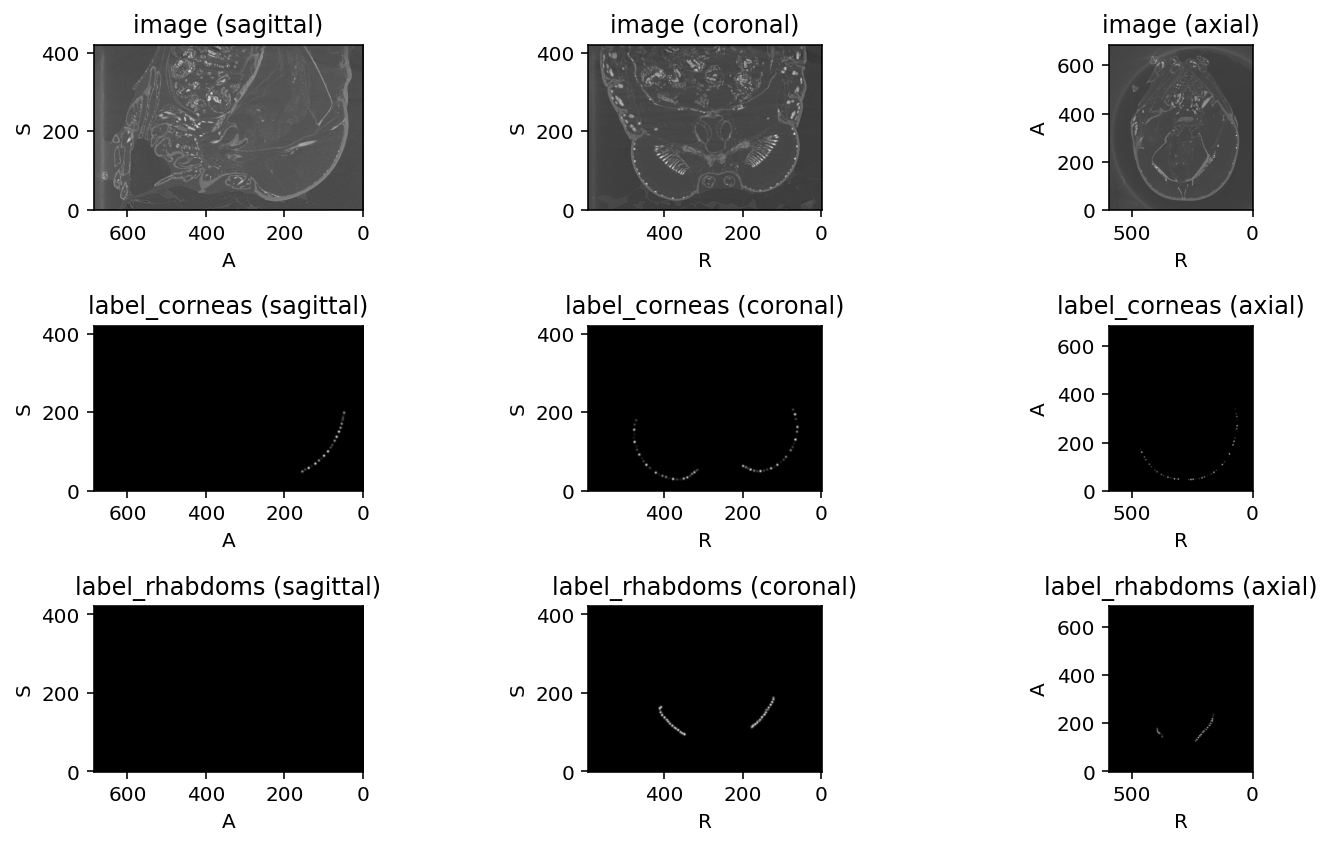

Subject(Keys: ('image', 'label_corneas', 'label_rhabdoms', 'filename'); images: 3)
ScalarImage(shape: (1, 595, 686, 421); spacing: (0.01, 0.01, 0.01); orientation: LPS+; memory: 655.5 MiB; dtype: torch.IntTensor)
ScalarImage(shape: (1, 595, 686, 421); spacing: (0.01, 0.01, 0.01); orientation: LPS+; memory: 655.5 MiB; dtype: torch.FloatTensor)
ScalarImage(shape: (1, 595, 686, 421); spacing: (0.01, 0.01, 0.01); orientation: LPS+; memory: 655.5 MiB; dtype: torch.FloatTensor)


In [6]:
one_subject = dataset[0]
one_subject.plot()
print(one_subject)
print(one_subject.image)
print(one_subject.label_corneas)
print(one_subject.label_rhabdoms)

## Transforms
### Normalisation
We will use the HistogramStandardization and the ZNormalization transforms to normalize our image intensity.

The images have been acquired by different mct scanners with different fixation and staining methods. We will apply some normalization techniques so that intensities are similarly distributed and within similar ranges.

Training the histogram is typically quite fast. It takes long here because of the fancy plotting.

In [8]:
def plot_histogram(axis, tensor, num_positions=30, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

fig, ax = plt.subplots(dpi=100)
for image_path in tqdm(images):
    tensor = tio.ScalarImage(image_path).data
    color = 'blue'
    plot_histogram(ax, tensor, color=color)
ax.set_xlim(-100, 2000)
ax.set_ylim(0, 0.004)
ax.set_title('Original histograms of all samples')
ax.set_xlabel('Intensity')
ax.grid()

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
landmarks = tio.HistogramStandardization.train(
    images,
    output_path='landmarks.npy',
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

In [ ]:
# this landmarks_dict lets us only apply the transform to the image, not the other ScalarImages (my labels) 
landmarks_dict = {'image': landmarks}

histogram_transform = tio.HistogramStandardization(landmarks_dict)

fig, ax = plt.subplots(dpi=100)
for i ,sample in enumerate(tqdm(dataset)):
    standard = histogram_transform(sample)
    tensor = standard.mri.data
    path = str(sample.mri.path)
    color = 'blue'
    plot_histogram(ax, tensor, color=color)
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.02)
ax.set_title('Intensity values of all samples after histogram standardization')
ax.set_xlabel('Intensity')
ax.grid()

Z-standardization or normalization means that our output data will have zero mean and unit variance. We do this using means and variances computed for each image, as opposed to the whole dataset, as Micro-ct values can vary a lot.

Below, we use only foreground values to compute the mean and variance. The foreground is approximated as all values above the mean, which typically works well.

In [ ]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.image.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()